# Introduction

Below a classification task is performed on a credit card fraud Kaggle dataset. The following algorithms are used for this task:

- Support Vector Classifier
- Decision Tree 
- Multi-Layer Perceptron
- Random Forest 
- PyTorch MLP

# Explore the dataset

Per its __[Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)__ website, the dataset contains credit card transactions that are labeled as genuine or fraudulent. Below, the dataset is loaded and its meta-data displayed. 

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('./creditcard.csv')
print(f'Shape: {data.shape}',end='\n\n')
data.info()

Shape: (284807, 31)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  fl

All of the data is numeric and none of the data is missing.

## Class balance

Below is the target variable's distribution.

In [2]:
pd.DataFrame({'Frequency':data['Class'].value_counts().sort_index().sort_index(),
                            'Distribution':data['Class'].value_counts(normalize=True).sort_index()})

,Frequency,Distribution
Class,,
0,284315,0.998273
1,492,0.001727


The target variable `Class` is binary and very imbalanced. There are only $\approx$ 0.2% positive examples. Therefore, the cost metric `F1 Score` will be used to evaluate models developed using the dataset.


## Normalization or standardization?

The dataset's `V*` variables are the result of a PCA transformation and don't need standardization. Reviewing their standard deviations, the PCA variable names appear to capture the explained variance of each feature in decreasing order. 

The variance explained by the first 25 of the 28 components is calculated below.

In [3]:
pca_summary_stats = data.iloc[:,1:29].describe()
pca_sum_var = pca_summary_stats.loc['std'].pow(2).sum()
sum(pca_summary_stats.loc['std'].iloc[1:25,].pow(2)/pca_sum_var)

0.8587489339504131

The first 25 components explain about $\approx$ 86% of the variance. For this analysis, all the PCA components will be included in the models developed. 

The  `Amount` and `Time` fields require standardization. A standard scaler will be used on the `Amount` variable.   

The `Time` variable contains the seconds elapsed between each transaction and the first transaction in the dataset. If I had some way of associating the transactions, this might be useful. As I can't, I will exclude the `Time` variable from the analysis.

In [4]:
X = data.iloc[:,1:30] # Exclude Time variable.
y = data.iloc[:,30]

# Standardize Amount.
from sklearn.preprocessing import StandardScaler
X[['Amount']] = StandardScaler().fit_transform(X[['Amount']])
X[['Amount']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Amount,284807.0,2.913952e-17,1.000002,-0.353229,-0.33084,-0.265271,-0.044717,102.362243


The scaled `Amount` looks correct.

## Split the dataset & model testing

The 50/50 split of training and test data is done below.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.50, stratify=y, random_state=0)

The code below performs hyper-parameter grid searches using SVC, Decision Tree, MLP, and Random Forest algorithms. A 10-fold CV is done to determine the best estimator for each grid search. Using the best estimator, the F1 scores are calculated. For each algorithm, a non-regularized and a regularized grid search is done.

# Classifier: SVC

Below, SVM classifier is fitted using the default regularization parameters and its performance calculated. This model and the ones that follow were fitted using a AWS `c6a.24xlarge` EC2 instance using 95 of its 96 CPUs.

In [6]:
from sklearn.svm import SVC
number_of_jobs=95

In [7]:
%%time
params = [{'C': [1]}]
gs = GridSearchCV(SVC(kernel='rbf'), param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# find best model score
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'C': 1}
Reclassification score: 0.8991228070175439
Test score: 0.7593052109181141
CPU times: user 1min 17s, sys: 776 ms, total: 1min 17s
Wall time: 2min 14s


To regularize the SVM, a grid search will be performed using the two hyper-parameters below:

- The `C` regularization parameter controls the strength of the `l2` penalty added to the algorithm's objective function.
- The `gamma` ($\gamma$) parameter is a multiplier that is applied as a regularization parameter within the kernel calculation.

In [8]:
%%time
params = [{'gamma': ['scale','auto'], 'C': [2.8, 2.9, 3, 3.1]}]
gs = GridSearchCV(SVC(kernel='rbf'), param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# Find best model score...
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'C': 2.9, 'gamma': 'scale'}
Reclassification score: 0.9379014989293363
Test score: 0.7990314769975787
CPU times: user 1min 4s, sys: 498 ms, total: 1min 4s
Wall time: 3min 43s


Displayed above are the hyper-parameters of the best performing estimator. Comparing the performance of the two models, the regularized SVM model generalized better on the test data.

# Classifier: Decision Tree

Below an un-pruned decision tree is fitted and evaluated. 

In [9]:
%%time
from sklearn.tree import DecisionTreeClassifier
params = [{'criterion':['gini', 'entropy']}]
gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# Find best model score...
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'criterion': 'entropy'}
Reclassification score: 1.0
Test score: 0.7276595744680852
CPU times: user 6.15 s, sys: 142 ms, total: 6.29 s
Wall time: 16 s


Next a pruned tree is fitted using `sklearn's` implementation of Minimal Cost-Complexity Pruning, an algorithm used to prune a tree to avoid over-fitting. The pruning occurs such that the subtree with the largest cost complexity that is smaller than ccp_alpha hyper-parameter will be chosen. To help select the best alpha value for the tree, the code below computes the pruning path during a Minimal Cost-Complexity pruning of a tree. These values will be used in the grid search that follows to find an optimal `ccp_alpha` value. 

CPU times: user 10.3 s, sys: 34.2 ms, total: 10.4 s
Wall time: 10.4 s


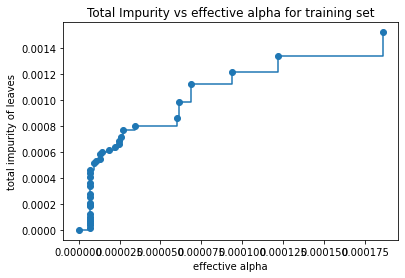

In [10]:
%%time
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_tr, y_tr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
restult = ax.set_title("Total Impurity vs effective alpha for training set")

The alphas calculated above will now be used in a grid search to find the best estimator. 

In [11]:
%%time
params = [{'ccp_alpha': ccp_alphas, 'criterion':['gini', 'entropy']}]
gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# Find best model score...
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'ccp_alpha': 6.870347409444549e-05, 'criterion': 'entropy'}
Reclassification score: 0.8812095032397409
Test score: 0.7847533632286996
CPU times: user 7.99 s, sys: 810 ms, total: 8.8 s
Wall time: 1min 28s


While the reclassification `F1 Score` is lower for the pruned decision tree, its test score is higher than the un-pruned tree.

# Classifier: MLP Classifier

Below, a non-regularized MLP is evaluated.

In [12]:
%%time
from sklearn.neural_network import MLPClassifier
params = [{'max_iter': [100, 500, 1000, 2000], 
           'learning_rate_init':[0.1, 0.01, 0.001, 0.0001], 'alpha':[0],
           'batch_size': [100, 200, 500]}]
mlp = MLPClassifier(hidden_layer_sizes=(28,10), random_state=0)
gs = GridSearchCV(mlp, param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# Find best model score...
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'alpha': 0, 'batch_size': 200, 'learning_rate_init': 0.001, 'max_iter': 100}
Reclassification score: 0.9120654396728016
Test score: 0.8134171907756813
CPU times: user 12.2 s, sys: 10.7 s, total: 22.9 s
Wall time: 1min 27s


Now a regularized grid search will be performed using the `sklearn` MLP implementation's `alpha` hyper-parameter. This parameter determines the strength of the `L2` regularization. 

In [13]:
%%time
params = [{'max_iter': [100, 500, 1000, 2000], 
           'learning_rate_init':[0.1, 0.01, 0.001, 0.0001], 'alpha':[0.01, 0.001, 0.0001],
           'batch_size': [100, 200, 500]}]
mlp = MLPClassifier(hidden_layer_sizes=(28,10), random_state=0)
gs = GridSearchCV(mlp, param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# Find best model score...
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'alpha': 0.01, 'batch_size': 200, 'learning_rate_init': 0.001, 'max_iter': 100}
Reclassification score: 0.8945147679324894
Test score: 0.8366013071895425
CPU times: user 15.8 s, sys: 14.5 s, total: 30.3 s
Wall time: 3min 27s


The hyper-parameters and performance of the best estimator are displayed above. Once again, the regularized model has better generalized performance.  

In [14]:
mlp_best_clf = gs.best_estimator_ 

# Classifier: Random Forest Classifier

Below a non-pruned Random Forest classifier is fitted and evaluated.

In [15]:
%%time
from sklearn.ensemble import RandomForestClassifier
def getRFModel(_estimators, _depth, _random_state=0, _alpha=0.0, _jobs=None):
    return  RandomForestClassifier(n_estimators=_estimators, max_depth=_depth, 
                                   criterion="entropy", class_weight="balanced_subsample", 
                                   random_state=_random_state, n_jobs=_jobs, ccp_alpha=_alpha) 

params = [{'n_estimators': [10, 100, 200], 'max_depth': [None, 8, 9, 10, 11]}]
gs = GridSearchCV(getRFModel(100, 10, 0, _alpha=0, _jobs=4), param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# Find best model score...
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'max_depth': 9, 'n_estimators': 100}
Reclassification score: 0.9473684210526316
Test score: 0.8240534521158129
CPU times: user 1min 1s, sys: 2.15 s, total: 1min 3s
Wall time: 2min 39s


Next, using the best best performing `ccp_alpha` found in the Decision Tree grid search, a regularized model is evaluated below.

In [16]:
%%time
params = [{'n_estimators': [10, 100, 200], 'max_depth': [None, 8, 9, 10, 11], 'ccp_alpha':[6.870347409444549e-05]}]
gs = GridSearchCV(getRFModel(100, 10, 0, _alpha=0, _jobs=4), param_grid=params, scoring='f1', cv=10, n_jobs=number_of_jobs)
gs.fit(X_tr, y_tr)
# Get best parameters...
print(gs.best_params_)
# Find best model score...
print(f'Reclassification score: {gs.score(X_tr, y_tr)}')
print(f'Test score: {gs.score(X_ts, y_ts)}')

{'ccp_alpha': 6.870347409444549e-05, 'max_depth': 9, 'n_estimators': 100}
Reclassification score: 0.9435483870967742
Test score: 0.8325991189427313
CPU times: user 58.3 s, sys: 264 ms, total: 58.5 s
Wall time: 2min 38s


As expected, the regularized RFC performs better than the non-regularized model, although the difference is small.

Next, a 10-fold CV is done using the best regularized Random Forest estimator.

In [17]:
rf_best_clf = gs.best_estimator_ 

In [18]:
from sklearn.model_selection import StratifiedKFold

def eval_classifier(_clf, _X, _y, _niter, return_metrics=False, debug=False):
    accs = []
    precisions = []
    recalls = []
    f1s = []
    for i in range(_niter):
        kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
        split = 1
        for tr_ix, ts_ix in kf.split(_X, _y):
            _clf.fit(_X[tr_ix], _y[tr_ix])
            y_pred = _clf.predict(_X[ts_ix])
            accs       += [accuracy_score (_y[ts_ix], y_pred)]
            precisions += [precision_score(_y[ts_ix], y_pred, zero_division=0)]
            recalls    += [recall_score   (_y[ts_ix], y_pred)]
            f1s        += [f1_score       (_y[ts_ix], y_pred)]
            if debug: print(f'Iteration {i}, Finished split {split}',end='\r')
            split += 1    
        if debug: print(' ' * 50, end='\r')            
    
    if return_metrics: 
        return [np.mean(accs),np.mean(precisions),np.mean(recalls),np.mean(f1s)]
    else:
        print(f'Stratified 10-Fold CV with {_niter} iterations')        
        print(f' Accuracy = {np.mean(accs):.3f} {chr(177)}{np.std(accs):.4f},', end ="")
        print(f' Precision = {np.mean(precisions):.3f} {chr(177)}{np.std(precisions):.4f},', end ="")
        print(f' Recall = {np.mean(recalls):.3f} {chr(177)}{np.std(recalls):.4f},', end ="")
        print(f' F1 Score = {np.mean(f1s):.3f} {chr(177)}{np.std(f1s):.4f}')

In [19]:
eval_classifier(rf_best_clf, X_tr.values, y_tr.values, 1, debug=True)

Stratified 10-Fold CV with 1 iterations           
 Accuracy = 1.000 ±0.0001, Precision = 0.909 ±0.0475, Recall = 0.796 ±0.0721, F1 Score = 0.845 ±0.0338


## Performance Summary

Regularization improved the performance of all the models. The regularized MLP had the best generalized performance with a test data `F1 Score`of $\approx$ 83.7%. Close behind was the regularized Random Forest Decision Tree at $\approx$ 83.3%. 


# Classifier: PyTorch neural network

Below, a ANN with two hidden layers is evaluated. The PyTorch code below came from Module 10's instructor provided notebook. However, I have modified the code to use a GPU (if its available) and changed all the activation functions to `ReLU`. The models were built on an AWS `p3.2xlarge` EC2 instance with 1 GPU and 8 CPUs. 

First, the data is reloaded as the code below was run on a different EC2 instance than the code above.

In [1]:
import pandas as pd
data = pd.read_csv('./creditcard.csv')
X = data.iloc[:,1:30] # Exclude Time variable.
y = data.iloc[:,30]
from sklearn.preprocessing import StandardScaler
X[['Amount']] = StandardScaler().fit_transform(X[['Amount']])
X[['Amount']].describe().transpose()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.50, stratify=y, random_state=0)

The training and test are converted to PyTorch tensors.  

In [3]:
import torch
torch.manual_seed(0)
X_tr_ten = torch.FloatTensor(X_tr.values)
y_tr_ten = torch.LongTensor(y_tr.values)
X_ts_ten = torch.FloatTensor(X_ts.values)
y_ts_ten = torch.LongTensor(y_ts.values)

The code below confirms `CUDA` is available. 

In [4]:
print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')  # CUDA optional - True when GPU present, CUDA installed
device_type = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PyTorch version= 2.0.1
CUDA available= False


Now, lets confirm a GPU is available. 

In [5]:
print(f'Number of GPUs: {torch.cuda.device_count()}')

Number of GPUs: 0


Below is the `PyTorchMLP` ANN implementation.

In [6]:
import numpy as np

class PyTorchMLP(torch.nn.Module):  
    def __init__(self, n_hidden=10, epochs=100, eta=0.001, minibatch_size=50, seed=0):
        super(PyTorchMLP, self).__init__()
        self.random = np.random.RandomState(seed)  # shuffle mini batches
        self.n_hidden = n_hidden  # size of the hidden layer
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work
        self.optimizer = None
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.model = None

    def init_layers(self, _M:int, _K:int) -> None:
        # data structure
        self.model = torch.nn.Sequential(
            torch.nn.Linear(_M, self.n_hidden).to(device_type), #self.n_hidden
            torch.nn.ReLU().to(device_type),
            torch.nn.Linear(self.n_hidden, self.n_hidden).to(device_type),
            torch.nn.ReLU().to(device_type),
            torch.nn.Linear(self.n_hidden, _K).to(device_type),
        )
    
    def predict(self, _X):
        _X = _X.to(device_type, non_blocking=True)
        assert self.model is not None
        self.model.eval()
        with torch.no_grad():
            y_pred = np.argmax(self.model(_X).cpu(), axis=1)
        self.model.train()
        return y_pred.numpy()

    def fit(self, _X_train, _y_train, info=False):
        import sys
        
        _X_train = _X_train.to(device_type, non_blocking=True)
        _y_train = _y_train.to(device_type, non_blocking=True).long()
        
        n_features= _X_train.shape[1]
        n_output= 2 #np.unique(_y_train).shape[0]  # number of class labels CHANGE
        
        self.init_layers(n_features, n_output)
        self.optimizer = torch.optim.Rprop(self.model.parameters(), lr=self.eta)  # connect model to optimizer

        for i in range(self.epochs):
            print(f'Epoc {i}...',end='\r')
            
            indices = np.arange(_X_train.shape[0])
            self.random.shuffle(indices)  # shuffle the data each epoch

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                self.optimizer.zero_grad()
                
                net_out = self.model(_X_train[batch_idx])
                
                loss = self.loss_func(net_out, _y_train[batch_idx])
                loss.backward()
                self.optimizer.step()
                
                if info:
                    sys.stderr.write(f"\r{i+1:03d} Loss: {loss.item():6.5f}")
                    sys.stderr.flush()
        return self

Below, a un-regularized ANN is evaluated. I did not have enough time to implement a search grid using PyTorch code. Therefore, the hyper-parameters below selected after a few rounds of pilot testing. 

In [6]:
%%time
mlp1 = PyTorchMLP(n_hidden=20, epochs=100, eta=0.001, minibatch_size=12000)
mlp1 = mlp1.to(device_type)
mlp1 = mlp1.fit(X_tr_ten, y_tr_ten)
print(f'Reclassification scores: {round(f1_score(y_tr, mlp1.predict(X_tr_ten)),4)}')
print(f'Test score: {round(f1_score(y_ts, mlp1.predict(X_ts_ten)),4)}')

Reclassification scores: 0.8316
Test score: 0.8043
CPU times: user 4.28 s, sys: 811 ms, total: 5.1 s
Wall time: 5.05 s


## Add Dropouts

Below, the ANN is regularized using a dropout probability of 10% after each hidden layer. 

In [7]:
%%time
# A derived class to have Dropout
class MLP2(PyTorchMLP):
    def init_layers(self, _M, _K):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(_M, self.n_hidden).to(device_type),
            torch.nn.ReLU().to(device_type),
            torch.nn.Dropout(0.1).to(device_type),
            torch.nn.Linear(self.n_hidden, self.n_hidden).to(device_type),
            torch.nn.ReLU().to(device_type),
            torch.nn.Dropout(0.1).to(device_type),
            torch.nn.Linear(self.n_hidden, _K).to(device_type),
        )

mlp2 = MLP2(n_hidden=20, epochs=100, eta=0.001, minibatch_size=12000)
mlp2 = mlp2.to(device_type)
mlp2 = mlp2.fit(X_tr_ten, y_tr_ten)
print(f'Reclassification scores: {round(f1_score(y_tr, mlp2.predict(X_tr_ten)),4)}')
print(f'Test score: {round(f1_score(y_ts, mlp2.predict(X_ts_ten)),4)}')

Reclassification scores: 0.8298
Test score: 0.8017
CPU times: user 3.22 s, sys: 43.6 ms, total: 3.27 s
Wall time: 3.22 s


Interestingly, the regularization did not result in better generalized performance. Mostly likely, grid search performance tuning would improve this.

## Performance Summary: 10-fold cross validation

As reported above, the 10-fold CV `F1 Score` for the regularized Random Forest was $\approx$ 84.5%.

Below, the CV performance is calculated for the two PyTorch ANNs.

In [8]:
from sklearn.model_selection import StratifiedKFold

def eval_classifier(_clf, _X, _y, _niter, return_metrics=False, debug=False):
    accs = []
    precisions = []
    recalls = []
    f1s = []
    for i in range(_niter):
        kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
        split = 1
        for tr_ix, ts_ix in kf.split(_X, _y):
            _clf.fit(_X[tr_ix], _y[tr_ix])
            y_pred = _clf.predict(_X[ts_ix])
            accs       += [accuracy_score (_y[ts_ix], y_pred)]
            precisions += [precision_score(_y[ts_ix], y_pred, zero_division=0)]
            recalls    += [recall_score   (_y[ts_ix], y_pred)]
            f1s        += [f1_score       (_y[ts_ix], y_pred)]
            if debug: print(f'Iteration {i}, Finished split {split}',end='\r')
            split += 1    
        if debug: print(' ' * 50, end='\r')            
    
    if return_metrics: 
        return [np.mean(accs),np.mean(precisions),np.mean(recalls),np.mean(f1s)]
    else:
        print(f'Stratified 10-Fold CV with {_niter} iterations')        
        print(f' Accuracy = {np.mean(accs):.3f} {chr(177)}{np.std(accs):.4f},', end ="")
        print(f' Precision = {np.mean(precisions):.3f} {chr(177)}{np.std(precisions):.4f},', end ="")
        print(f' Recall = {np.mean(recalls):.3f} {chr(177)}{np.std(recalls):.4f},', end ="")
        print(f' F1 Score = {np.mean(f1s):.3f} {chr(177)}{np.std(f1s):.4f}')

In [9]:
eval_classifier(mlp1, X_tr_ten, y_tr_ten, 1, debug=True)

Stratified 10-Fold CV with 1 iterations           
 Accuracy = 0.999 ±0.0002, Precision = 0.843 ±0.0719, Recall = 0.788 ±0.0749, F1 Score = 0.810 ±0.0451


In [10]:
eval_classifier(mlp2, X_tr_ten, y_tr_ten, 1, debug=True)

Stratified 10-Fold CV with 1 iterations           
 Accuracy = 0.999 ±0.0001, Precision = 0.845 ±0.0703, Recall = 0.767 ±0.0921, F1 Score = 0.798 ±0.0454


The Random Forest has a significantly better CV `F1 Score`. However, as mentioned, the ANN performance could be improved with some hyper-parameter tunning. 